In [1]:
import sys
import os
# os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import numpy as np
import time

# Add the parent directory (project root) to sys.path
script_dir = os.path.dirname(os.curdir)
parent_dir = os.path.abspath(os.path.join(script_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# ------------------------------------------------------------------
#! General
import QES.general_python.common.binary as Binary
from QES.general_python.common.timer import Timer, timeit
from QES.general_python.common.binary import JAX_AVAILABLE, get_backend, get_global_logger
from QES.general_python.common.plot import Plotter, MatrixPrinter, colorsCycle, linestylesCycle

# ------------------------------------------------------------------
#! Lattice
from QES.general_python.lattices import choose_lattice, plot_bonds

# ------------------------------------------------------------------
#! Sampler
import QES.Solver.MonteCarlo.sampler as Sampler
import QES.NQS.nqs as NQS
import QES.NQS.nqs_train as NQST
import QES.NQS.tdvp as TDVP
from QES.general_python.ml.schedulers import EarlyStopping, ConstantScheduler, ExponentialDecayScheduler

# ------------------------------------------------------------------
#! ODE solver
from QES.general_python.algebra.ode import choose_ode

# ------------------------------------------------------------------
#! Networks
from QES.general_python.ml.net_impl.networks.net_rbm import RBM
from QES.general_python.ml.net_impl.networks.net_cnn import CNN
from QES.general_python.ml.net_impl.activation_functions import relu_jnp, tanh_jnp, sigmoid_jnp, leaky_relu_jnp, elu_jnp, poly6_jnp, softplus_jnp

# ------------------------------------------------------------------
#! Hamiltonians
from QES.general_python.algebra.linalg import act, overlap
from QES.Algebra.Model.dummy import DummyHamiltonian
from QES.Algebra.Model.Interacting.Spin.heisenberg_kitaev import HeisenbergKitaev
from QES.Algebra.Model.Interacting.Spin.transverse_ising import TransverseFieldIsing
from QES.Algebra.Properties import time_evo

# ------------------------------------------------------------------
#! Linear algebra
import QES.general_python.algebra.solvers.stochastic_rcnfg as SR
import QES.general_python.algebra.solvers as solvers
import QES.general_python.algebra.preconditioners as preconditioners

# ------------------------------------------------------------------

from QES.Algebra.Operator.operator import initial_states, create_operator
#! Spin operators
import QES.Algebra.Operator.operators_spin as op_spin
#! Fermionic operators
import QES.Algebra.Operator.operators_spinless_fermions as op_sferm

#! Backends
if JAX_AVAILABLE:
    import jax
    import jax.numpy as jnp
else:
    jax = None
    jnp = None

# ------------------------------------------------------------------
# lattice_type        = 'honeycomb'
lattice_type        = 'square'
lx, ly, lz          = 12, 1, 1
# lx, ly, lz          = 10, 1, 1
# ------------------------------------------------------------------
scheduler           = 'ExponentialDecay'
ode_solver_type     = 'Euler'
# ode_solver_type   = 'Heun'
# ode_solver_type   = 'AdaptiveHeun'
# ode_solver_type   = 'RK4'
lr                  = 0.03 # is also dt
# ------------------------------------------------------------------
network_type        = 'RBM'
# network_type        = 'CNN'
alpha               = 4
# ------------------------------------------------------------------
# ham_type            = 'HeisenbergKitaev'
ham_type            = 'TransverseFieldIsing'
# ham_type            = 'DummyHamiltonian'
ham_dtype           = jnp.float32
# ------------------------------------------------------------------

logger              = get_global_logger()
backend             = 'jax'
seed                = 1234
dtypex              = jnp.complex128
be_modules          = get_backend(backend, random=True, seed=seed, scipy=True)
backend_np, (rng, rng_k), backend_sp = be_modules if isinstance(be_modules, tuple) else (be_modules, (None, None), None)

# ------------------------------------------------------------------

#! Lattice
lattice = choose_lattice(
                typek = lattice_type,
                lx    = lx,
                ly    = ly,
                lz    = lz,
                bc    = 'mbc')
ns, mult, st_shape = lattice.ns, lattice.ns // (lx * ly * lz), (lattice.ns, )

19_05_2025_12-43_05 [INFO] Log file created: ./log/QES_19_05_2025_12-43_05.log
19_05_2025_12-43_05 [INFO] Log level set to: info
19_05_2025_12-43_05 [INFO] ############Global logger initialized.############
19_05_2025_12-43_05 [INFO] JAX backend available and successfully imported
19_05_2025_12-43_05 [INFO] 	JAX 64-bit precision enabled.
19_05_2025_12-43_05 [INFO] Setting JAX as the active backend.
19_05_2025_12-43_05 [INFO] **************************************************
19_05_2025_12-43_05 [INFO] Backend Configuration:
19_05_2025_12-43_05 [INFO] 		NumPy Version: 1.26.4
19_05_2025_12-43_05 [INFO] 		SciPy Version: 1.13.1
19_05_2025_12-43_05 [INFO] 		JAX Version: 0.6.0
19_05_2025_12-43_05 [INFO] 		Active Backend: jax
19_05_2025_12-43_05 [INFO] 			JAX Available: True
19_05_2025_12-43_05 [INFO] 			Default Seed: 42
19_05_2025_12-43_05 [INFO] 		JAX Backend Details:
19_05_2025_12-43_05 [INFO] 				Main Module: jax.numpy
19_05_2025_12-43_05 [INFO] 				Random Module: jax.random (+ PRNGKey)
1

In [2]:
nh          = 2**ns
use_ed      = nh <= 2**20
use_lanczos = nh > 2**12

# ------------------------------------------------------------------
#! Operators
# ------------------------------------------------------------------

sig_z = op_spin.sig_z(
    lattice = lattice,
    ns      = lattice.ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0]
)

sig_x = op_spin.sig_x(
    lattice = lattice,
    ns      = lattice.ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0]
)

sig_z_c = op_spin.sig_z(
    lattice = lattice,
    ns      = lattice.ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0, 1]
)

sig_x_c = op_spin.sig_x(
    lattice = lattice,
    ns      = lattice.ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0, 1]
)

# -------------------------------------------------------------------
#! Quenches
# -------------------------------------------------------------------

sites_all       = []
operators_inv   = []
sites           = [0]

#! local
operators_inv.append(
    op_spin.sig_z(
        lattice     = lattice,
        type_act    = op_spin.OperatorTypeActing.Global,
        sites       = sites,
        spin_value  = 1.0)
)

operators_inv.append(
    op_spin.sig_x(
        lattice     = lattice,
        type_act    = op_spin.OperatorTypeActing.Global,
        sites       = sites,
        spin_value  = 1.0)
)

#! correlations
sites_corr = [0, 3]

operators_inv.append(
    op_spin.sig_z(
        lattice     = lattice,
        type_act    = op_spin.OperatorTypeActing.Global,
        sites       = sites_corr,
        spin_value  = 1.0)
)

operators_inv.append(
    op_spin.sig_x(
        lattice     = lattice,
        type_act    = op_spin.OperatorTypeActing.Global,
        sites       = sites_corr,
        spin_value  = 1.0)
)

#! k-space
# k       = 1.0
# sites_k = jnp.arange(0, lattice.ns, dtype=jnp.int32)
# operators_inv.append(
#     create_operator(
#         type_act        =   op_spin.OperatorTypeActing.Global,
#         op_func_int     =   op_spin.sigma_k_int_np,
#         op_func_np      =   None,
#         op_func_jnp     =   op_spin.sigma_k_inv_jnp,
#         ns              =   lattice.ns,
#         sites           =   sites_k,
#         name            =   'sk',
#         extra_args      =   (k, True, 1.0),
#         modifies        =   False,
#     )
# )

#! matrices
if use_ed:
    sig_x_op_mat        = sig_x.matrix(  dim = nh, use_numpy = True)
    sig_z_op_mat        = sig_z.matrix(  dim = nh, use_numpy = True)
    sig_x_op_mat_c      = sig_x_c.matrix(dim = nh, use_numpy = True)
    sig_z_op_mat_c      = sig_z_c.matrix(dim = nh, use_numpy = True)
    # modifiers
    sig_x_op_mat_inv    = operators_inv[0].matrix(dim=nh, use_numpy=True)
    sig_z_op_mat_inv    = operators_inv[1].matrix(dim=nh, use_numpy=True)
    sig_x_op_mat_inv_c  = operators_inv[2].matrix(dim=nh, use_numpy=True)
    sig_z_op_mat_inv_c  = operators_inv[3].matrix(dim=nh, use_numpy=True)
    # sig_k_op_mat_inv    = operators_inv[4].matrix(dim=nh, use_numpy=True)
else:
    sig_x_op_mat        = None
    sig_z_op_mat        = None
    sig_x_op_mat_c      = None
    sig_z_op_mat_c      = None
    # modifiers
    sig_x_op_mat_inv    = None
    sig_z_op_mat_inv    = None
    sig_x_op_mat_inv_c  = None
    sig_z_op_mat_inv_c  = None
    sig_k_op_mat_inv    = None

19_05_2025_12-43_05 [INFO] 		->[HilbertSpace] Inferred Ns=12 from Nh=4096 and Nhl=2
19_05_2025_12-43_06 [INFO] 		->[HilbertSpace] Inferred Ns=12 from Nh=4096 and Nhl=2
19_05_2025_12-43_06 [INFO] 		->[HilbertSpace] Inferred Ns=12 from Nh=4096 and Nhl=2
19_05_2025_12-43_06 [INFO] 		->[HilbertSpace] Inferred Ns=12 from Nh=4096 and Nhl=2
19_05_2025_12-43_06 [INFO] 		->[HilbertSpace] Inferred Ns=12 from Nh=4096 and Nhl=2
19_05_2025_12-43_06 [INFO] 		->[HilbertSpace] Inferred Ns=12 from Nh=4096 and Nhl=2
19_05_2025_12-43_06 [INFO] 		->[HilbertSpace] Inferred Ns=12 from Nh=4096 and Nhl=2
19_05_2025_12-43_06 [INFO] 		->[HilbertSpace] Inferred Ns=12 from Nh=4096 and Nhl=2


In [3]:
if ham_type == 'HeisenbergKitaev':
    hamil = HeisenbergKitaev(lattice    = lattice,
                        hilbert_space   = None,
                        hx              = 0.0,
                        hz              = 0.0,
                        kx              = 1.0,
                        ky              = 1.0,
                        kz              = 1.0,
                        j               = 0.0,
                        dlt             = 1.0,
                        dtype           = ham_dtype,
                        use_forward     = False,
                        backend         = backend)

elif ham_type == 'TransverseFieldIsing':
    hamil = TransverseFieldIsing(
                        lattice        = lattice,
                        hilbert_space  = None,
                        hz             = 2.5,
                        hx             = -1.4,
                        # hx             = -0.7,    # same, but we use spin = 1/2
                        j              = 4.0,          
                        # j              = -1.0,    # same, but we use spin = 1/2          
                        dtype          = ham_dtype,
                        backend        = backend
                )
elif ham_type == 'DummyHamiltonian':
    hamil = DummyHamiltonian(
                        lattice        = lattice,
                        hilbert_space  = None,
                        dtype          = ham_dtype,
                        backend        = backend
                )
else:
    raise ValueError(f"Unknown Hamiltonian type: {ham_type}")

logger.title('Hamiltonian', desired_size=150, fill='#', color='red')
hamil

19_05_2025_12-43_06 [INFO] 	->[Transverse Field Ising Model] Building TFIM operator list...
19_05_2025_12-43_06 [INFO] 		->[Transverse Field Ising Model] Adding modifying operator Operator(Sx/L, type_acting=Local, eigval=1.0, type=Other) at site 0 (sites: [0]) with multiplier 1.399999976158142
19_05_2025_12-43_06 [INFO] 		->[Transverse Field Ising Model] Adding modifying operator Operator(Sx/L, type_acting=Local, eigval=1.0, type=Other) at site 1 (sites: [1]) with multiplier 1.399999976158142
19_05_2025_12-43_06 [INFO] 		->[Transverse Field Ising Model] Adding modifying operator Operator(Sx/L, type_acting=Local, eigval=1.0, type=Other) at site 2 (sites: [2]) with multiplier 1.399999976158142
19_05_2025_12-43_06 [INFO] 		->[Transverse Field Ising Model] Adding modifying operator Operator(Sx/L, type_acting=Local, eigval=1.0, type=Other) at site 3 (sites: [3]) with multiplier 1.399999976158142
19_05_2025_12-43_06 [INFO] 		->[Transverse Field Ising Model] Adding modifying operator Operator

TFIM(Ns=12,J=4.0,hx=-1.4)

19_05_2025_12-43_06 [INFO] #################Diagonalization#################
19_05_2025_12-43_06 [INFO] 			->[Transverse Field Ising Model] JAX is available but NumPy is forced...
19_05_2025_12-43_06 [INFO] 		->[Transverse Field Ising Model] Calculating the Hamiltonian matrix using NumPy...
19_05_2025_12-43_08 [INFO] 	->Time to build Hamiltonian: 1.65e+00 seconds
19_05_2025_12-43_12 [INFO] 	->Time to diagonalize Hamiltonian: 3.77e+00 seconds
19_05_2025_12-43_12 [INFO] 		->Eigenvalue 0: -27.9033
19_05_2025_12-43_12 [INFO] 			->Expectation value of Sx/0 in state 0: -0.1074
19_05_2025_12-43_12 [INFO] 			->Expectation value of Sz/0 in state 0: 0.4883
19_05_2025_12-43_12 [INFO] 			->Expectation value of Sx/0-1 in state 0: 0.0139
19_05_2025_12-43_12 [INFO] 			->Expectation value of Sz/0-1 in state 0: 0.2386
19_05_2025_12-43_12 [INFO] 		->Eigenvalue 1: -21.6802
19_05_2025_12-43_12 [INFO] 			->Expectation value of Sx/0 in state 1: -0.1350
19_05_2025_12-43_12 [INFO] 			->Expectation value of Sz

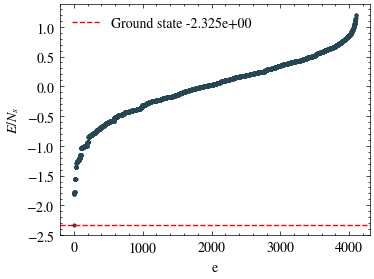

In [4]:
def perform_ed_nqs(
        hamil       : DummyHamiltonian,
        *,
        use_lanczos = False,
        k           = 50,
        # printing info
        state_info  = 1,
        operators   = { sig_x.name: sig_x_op_mat },
        plot_energy = False):
    
    logger.title('Diagonalization', desired_size=50, fill='#', color='red')
    
    _, t = timeit(hamil.build, use_numpy=True)    
    logger.info(f"Time to build Hamiltonian: {t:.2e} seconds", color='green', lvl=1)

    _, t = timeit(hamil.diagonalize, method = 'eigh' if not use_lanczos else 'lanczos', k = k)
    logger.info(f"Time to diagonalize Hamiltonian: {t:.2e} seconds", color='yellow', lvl=1)

    eig_val = hamil.get_eigval()
    eig_vec = hamil.get_eigvec()
    
    if state_info is not None and isinstance(state_info, int):
        for i in range(state_info):
            logger.info(f"Eigenvalue {i}: {eig_val[i]:.4f}", color='green', lvl=2)
            for op_name, op_mat in operators.items():
                if op_mat is not None:
                    exp_val = overlap(eig_vec[:, i], op_mat, backend = np)
                    logger.info(f"Expectation value of {op_name} in state {i}: {exp_val:.4f}", color='green',lvl=3)
                else:
                    logger.info(f"Operator {op_name} is not available for expectation value calculation", color='red', lvl=3)
    
    if plot_energy and eig_val is not None and len(eig_val) > 1:
        fig, ax = Plotter.get_subplots(
            nrows       = 1,
            ncols       = 1,
            figsize     = (4, 3),
            dpi         = 100,
        )
        x   = np.arange(0, len(eig_val))
        y   = eig_val
        ax[0].plot(x, y / lattice.ns, 'o', markersize=2)
        ax[0].set_xlabel(r'$\mathcal{e}$')
        ax[0].set_ylabel(r'$E/N_s$')
        ax[0].axhline(eig_val[0] / lattice.ns, color='r', linestyle='--', label=f'Ground state {eig_val[0] / lattice.ns :.3e}')
        ax[0].legend()
    return eig_val, eig_vec

if use_ed:
    eig_val, eig_vec = perform_ed_nqs(
        hamil       =   hamil,
        use_lanczos =   use_lanczos,
        operators   = {
                        sig_x.name      : sig_x_op_mat,
                        sig_z.name      : sig_z_op_mat,
                        sig_x_c.name    : sig_x_op_mat_c,
                        sig_z_c.name    : sig_z_op_mat_c
                    },
        plot_energy =   True,
        state_info  =   3
    )
else:
    eig_val, eig_vec = [None], [None]

19_05_2025_12-44_50 [INFO] ##################Time evolution##################
19_05_2025_12-44_50 [INFO] 		->State: 0
19_05_2025_12-44_50 [INFO] 			->Operator: Sx/0
19_05_2025_12-44_50 [INFO] 			->Operator: Sz/0
19_05_2025_12-44_51 [INFO] 			->Operator: Sx/0-1
19_05_2025_12-44_52 [INFO] 			->Operator: Sz/0-1
19_05_2025_12-44_53 [INFO] 		->State: 1
19_05_2025_12-44_53 [INFO] 			->Operator: Sx/0
19_05_2025_12-44_53 [INFO] 			->Operator: Sz/0
19_05_2025_12-44_54 [INFO] 			->Operator: Sx/0-1
19_05_2025_12-44_55 [INFO] 			->Operator: Sz/0-1
19_05_2025_12-44_56 [INFO] 		->State: 2
19_05_2025_12-44_56 [INFO] 			->Operator: Sx/0
19_05_2025_12-44_57 [INFO] 			->Operator: Sz/0
19_05_2025_12-44_57 [INFO] 			->Operator: Sx/0-1
19_05_2025_12-44_58 [INFO] 			->Operator: Sz/0-1


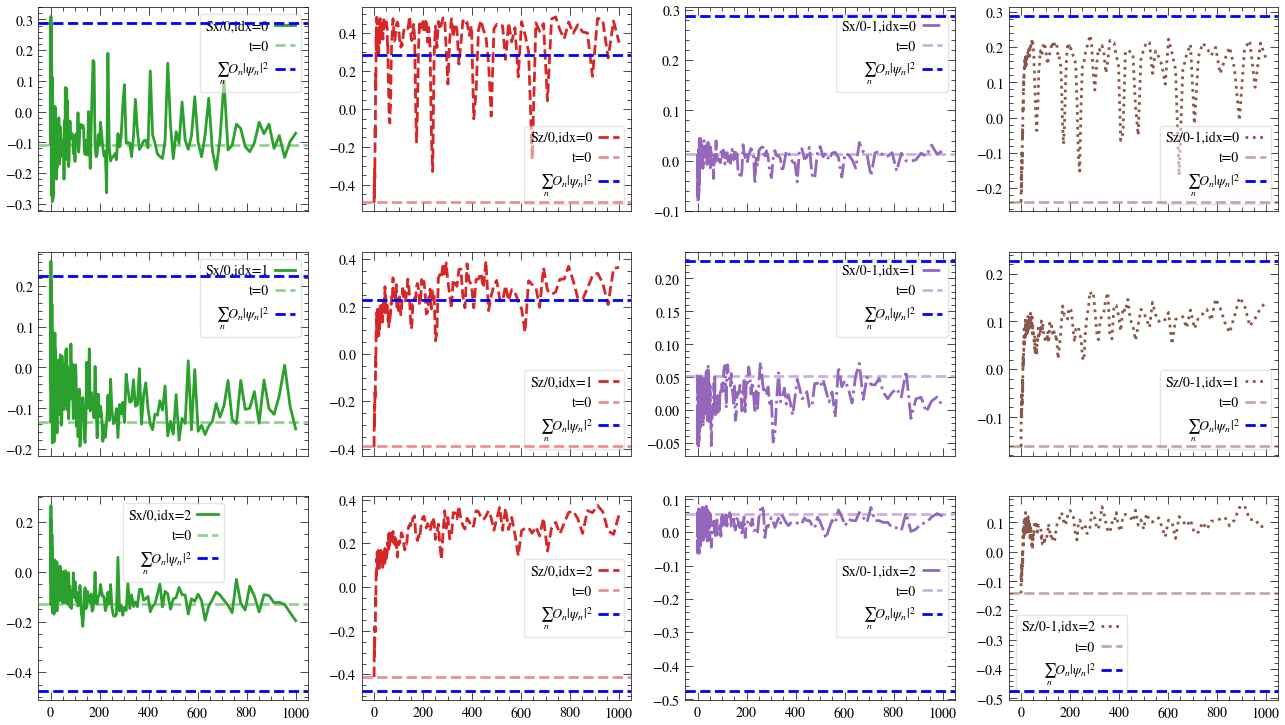

In [9]:
# ------------------------------------------------------------------

def plot_time_evo_ed_nqs(values_evo, quench_op_mats, state_info):
    
    fig, ax = Plotter.get_subplots(
        ncols       = len(quench_op_mats),
        nrows       = state_info,
        figsize     = (4 * len(quench_op_mats), 3 * state_info),
        dpi         = 100,
        sharex      = True)
    
    n_ops       = len(quench_op_mats)
    linestyles  = [next(linestylesCycle) for _ in range(n_ops)]
    colors      = [next(colorsCycle) for _ in range(n_ops)]
    
    for i in range(state_info):
        for j, op_name in enumerate(quench_op_mats.keys()):
            
            idx     = j + i * n_ops
            x       = values_evo[i]['time']
            y       = np.real(values_evo[i][op_name])
            Plotter.plot(
                ax          = ax[idx],
                x           = x,
                y           = y,
                label       = f'{op_name},idx={i}',
                color       = colors[j],
                ls          = linestyles[j],
            )
            Plotter.hline(ax[idx], val=y[0], color=colors[j], ls='--', label='t=0', alpha=0.5, lw = 2)
            # diagonal ensemble
            Plotter.hline(ax[idx], val=values_evo[i]['diagonal'], color='b', ls='--', label=r'$\sum_n O_n |\psi_n|^2$')
            
            Plotter.set_tickparams(ax=ax[idx])
            Plotter.set_legend(ax=ax[idx], frameon=True, framealpha=0.5)

def perform_time_evo_ed_nqs(
    times           : np.ndarray,
    eig_val         : np.ndarray,
    eig_vec         : np.ndarray,
    *,
    use_lanczos     = False,
    krylov_vec      = None,
    state_info      = 1,
    quench_op_mat   = sig_z_op_mat_inv,
    quench_op_mats  = {
        sig_x.name : sig_x_op_mat_inv,
    },
    plot_evo        = False,
    ):
    
    logger.title('Time evolution', desired_size=50, fill='#', color='red')
    if eig_vec is None:
        raise ValueError("Eigenvector is None")
    if eig_val is None:
        raise ValueError("Eigenvalue is None")
    if quench_op_mats is None:
        raise ValueError("Quench operator matrix is None")
    if times is None:
        raise ValueError("Times array is None")
    if state_info is None or not isinstance(state_info, int):
        raise ValueError("State info is None or not an integer")

    #! prepare values
    values_evo = [{ 'time' : times, 'diagonal' : 0.0 } for _ in range(state_info)]
    for op_name in quench_op_mats.keys():
        for i in range(state_info):
            values_evo[i][op_name] = np.zeros_like(times, dtype=np.complex128)
    
    #! perform
    if use_lanczos and krylov_vec is not None:
        # Use Krylov vectors for time evolution
        pass 
    elif not use_lanczos:
        for i in range(state_info):
            #! time evolution
            logger.info(f"State: {i}", color='green', lvl=2)
            state = eig_vec[:, i]
            #! go through operators
            for op_name, quench_op_m in quench_op_mats.items():
                logger.info(f"Operator: {op_name}", color='green', lvl=3)
                quenched_state              = quench_op_mat @ state
                quenched_state             /= np.linalg.norm(quenched_state)
                quenched_overlaps           = eig_vec.T @ quenched_state
                values_evo[i][op_name][0]   = overlap(quenched_state, quench_op_m, backend=np) # initial value
                #diagonal ensemble
                
                # diagonal of matrix
                diag_mat                    = eig_vec.T @ quench_op_m @ eig_vec
                values_evo[i]['diagonal']   = time_evo.diagonal_enemble(overlaps=quenched_overlaps, diag_mat=diag_mat)
                
                # evolve
                # Vectorized time evolution for all times (excluding t=0)
                t_arr = times[1:]
                # Compute all evolved states at once
                evolved_states              = np.exp(-1j * np.outer(eig_val, t_arr)) * quenched_overlaps[:, np.newaxis]
                # Project back to basis
                quenched_states_t           = eig_vec @ evolved_states  # shape: (dim, len(t_arr))
                # Compute expectation values for all times
                quenched_values_t           = np.einsum('ij,ji->i', np.conj(quenched_states_t.T), quench_op_m @ quenched_states_t)
                values_evo[i][op_name][1:]  = quenched_values_t
    if plot_evo:
        plot_time_evo_ed_nqs(values_evo, quench_op_mats, state_info)
    return values_evo


if use_ed:
    # times           = np.linspace(0, 10, 500)
    times = np.logspace(-2, 3, 500)
    quench_op_mats  = {
        sig_x.name      : sig_x_op_mat,
        sig_z.name      : sig_z_op_mat,
        sig_x_c.name    : sig_x_op_mat_c,
        sig_z_c.name    : sig_z_op_mat_c
    }
    values_evo  = perform_time_evo_ed_nqs(
        times           = times,
        eig_val         = eig_val,
        eig_vec         = eig_vec,
        use_lanczos     = use_lanczos,
        krylov_vec      = None,
        state_info      = 3,
        quench_op_mat   = sig_z_op_mat_inv,
        quench_op_mats  = quench_op_mats,
        plot_evo        = True
    )
else:
    values_evo = None

In [93]:
if network_type == 'RBM':
    net = RBM(
        input_shape         = st_shape, 
        n_hidden            = int(alpha * ns),
        dtype               = dtypex,
        param_dtype         = dtypex,
        seed                = seed,
        visible_bias        = True,
        bias                = True,
    )
elif network_type == 'CNN':
    net     = CNN(
        input_shape         = st_shape,
        reshape_dims        = (lx, ly * mult),
        features            = (8,) * alpha,
        strides             = [(1, 1)] * alpha,
        kernel_sizes        = [(2, 2)] * alpha,
        activations         = [elu_jnp] * alpha,
        dtype               = dtypex,
        param_dtype         = dtypex,
        final_activation    = elu_jnp,
        seed                = seed,
        output_shape        = (1,)
    )
else:
    raise ValueError(f"Unknown network type: {network_type}")
net

19_05_2025_12-19_18 [INFO] 	->[GeneralNet] Holomorphic check result (||∇Re[f] - i*∇Im[f]|| / ||∇Re[f]|| ≈ 0): True
19_05_2025_12-19_18 [INFO] 	->[GeneralNet] FlaxInterface initialized: dtype=complex128, is_complex=True, nparams=636, is_holomorphic=True


ComplexRBM(shape=(12,), hidden=48, bias=on, visible_bias=on, dtype=complex128, params=636, analytic_grad=False, initialized)

In [94]:
n_chains        = 10
n_samples       = 200
n_therm_steps   = 25
sampler         = Sampler.MCSampler(
                    net             = net,
                    shape           = st_shape,
                    rng             = rng,
                    rng_k           = rng_k,
                    numchains       = n_chains,
                    numsamples      = n_samples,
                    sweep_steps     = min(ns, 28),
                    backend         = backend_np,
                    therm_steps     = n_therm_steps,
                    mu              = 2.0,
                    seed            = seed,
                    dtype           = dtypex,
                    statetype       = np.float32,
                    makediffer      = True
                )
do_tests    = False
sampler_fun = sampler.get_sampler_jax()
sampler

MCSampler(shape=(12,), mu=2.0, beta=1.0, therm_steps=25, sweep_steps=12, numsamples=200, numchains=10, backend=jax)

In [95]:
n_batch = 128
nqs     = NQS.NQS(
            net             = net,
            sampler         = sampler,
            hamiltonian     = hamil,
            lower_betas     = None,
            lower_states    = None,
            seed            = seed,
            beta            = 1.0,
            mu              = sampler.get_mu(),
            shape           = st_shape,
            backend         = backend_np,
            batch_size      = n_batch,
            dtype           = dtypex,
            directory       = "/home/klimak/Codes/QuantumEigenSolver/Python/projects/models/"
        )
nqs.load_weights()

{'VisibleToHidden': {'bias': array([ 0.33742001-0.01728241j, -0.04244899+0.05148776j,
          0.08127832+0.01179392j,  0.03473398-0.15596344j,
         -0.17172551-0.23537788j, -0.29491848-0.01821052j,
          0.33184252+0.1562805j ,  0.0350474 -0.00186385j,
          0.08573111-0.05826176j,  0.20135562+0.00391937j,
         -0.10926345+0.11552665j, -0.03170322+0.07209983j,
         -0.27831032-0.17216406j,  0.25735657+0.16117508j,
         -0.05470471+0.03979504j,  0.07044312+0.01631216j,
         -0.30412755-0.07103697j, -0.12440398+0.11354938j,
         -0.10799205+0.40049819j,  0.21066031+0.25229655j,
         -0.16829389-0.03098787j,  0.03552474+0.03259766j,
          0.153618  -0.11047983j, -0.02692991+0.09724693j,
          0.06508215-0.15912716j, -0.02092392-0.0519204j ,
         -0.32685424+0.02035346j, -0.20458343-0.14976292j,
          0.11165572-0.22150086j, -0.10507805+0.07748686j,
         -0.14177841-0.18756758j,  0.0797268 +0.01248922j,
         -0.27954323-0.035363

### Test observables after loading a model

19_05_2025_10-54_19 [INFO] Operator(Sz/0, type_acting=Global, eigval=1.0, type=Other): ⟨O⟩ = (0.4880+0.0000j) ± (0.1089)  (N=2000)
19_05_2025_10-54_19 [INFO] 		->ref = 0.4883 - rel.err = 0.06 %
19_05_2025_10-54_19 [INFO] Operator(Sx/0, type_acting=Global, eigval=1.0, type=Other): ⟨O⟩ = (-0.1103-0.0003j) ± (0.5162)  (N=2000)
19_05_2025_10-54_19 [INFO] 		->ref = -0.1074 - rel.err = 2.74 %
19_05_2025_10-54_20 [INFO] Operator(Sz/0-1, type_acting=Global, eigval=1.0, type=Other): ⟨O⟩ = (0.2395+0.0000j) ± (0.0717)  (N=2000)
19_05_2025_10-54_20 [INFO] 		->ref = 0.2386 - rel.err = 0.39 %
19_05_2025_10-54_20 [INFO] Operator(Sx/0-1, type_acting=Global, eigval=1.0, type=Other): ⟨O⟩ = (0.0092-0.0001j) ± (0.0375)  (N=2000)
19_05_2025_10-54_20 [INFO] 		->ref = 0.0139 - rel.err = 34.15 %
19_05_2025_10-54_21 [INFO] Energy: E = (-2.7825e+01+6.9379e-05j) ± (0.2892) (N=2000)
None
None
None
None
19_05_2025_10-54_22 [INFO] sample: 1.78e+00 s
19_05_2025_10-54_22 [INFO] obs_0: 2.75e-01 s
19_05_2025_10-54_22 [

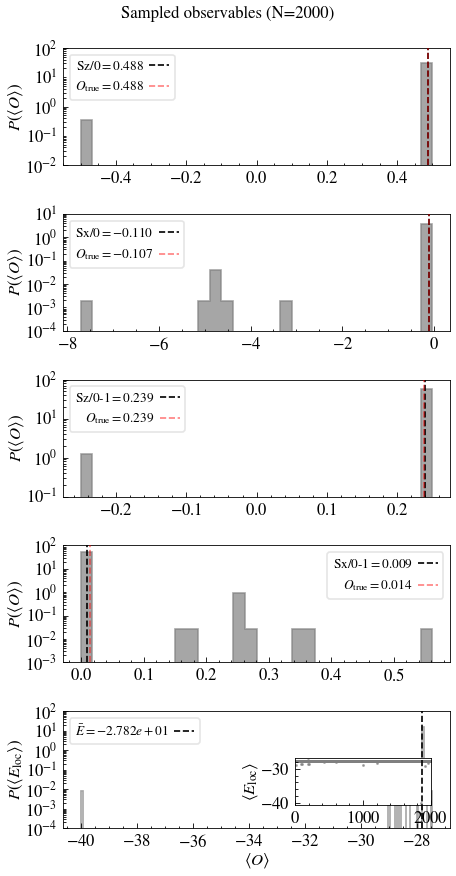

In [16]:
results, energy, timings = nqs.eval_observables(
    operators      = [sig_z, sig_x, sig_z_c, sig_x_c],
    true_values    = [ed_sig_z_exp, ed_sig_x_exp, ed_sig_z_exp_c, ed_sig_x_exp_c],
    n_chains       = n_chains,
    n_samples      = n_samples,
    batch_size     = 100,
    logger         = logger,
    plot           = True,
    get_energy     = True,
    bins           = 200,
    true_en        = eigv[0],
    plot_kwargs    = {
        # 'xlim_0'    : (-0.5, 0.1),
        # 'xlim_1'    : (-0.5, 0.1),
        'inset_axes': (0.6, 0.2, 0.35, 0.4),
    }
)

### State modifier

#### On initial states test.

In [41]:
# test modifiers
_, _, st_jax = initial_states(lattice.ns, display=True)
st_jax       = (st_jax - 0.5) * 2

for modifier in operators_inv[:2]:
    st_out, st_val = modifier.jax(st_jax)
    logger.title([modifier.name], desired_size=50, fill='#', color='red')
    logger.info(f"Modified state: {st_out[0]}")
    logger.info(f"Original state: {st_jax}")
    logger.info(f"Modified state value: {st_val}")
    logger.info(f"Modified state shape: {st_out.shape}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

19_05_2025_11-01_23 [INFO] ########################['sz/0']##################
19_05_2025_11-01_23 [INFO] Modified state: [ 1.  1. -1.  1. -1.  1.  1.  1. -1.  1. -1. -1.]
19_05_2025_11-01_23 [INFO] Original state: [ 1.  1. -1.  1. -1.  1.  1.  1. -1.  1. -1. -1.]
19_05_2025_11-01_23 [INFO] Modified state value: [1.]
19_05_2025_11-01_23 [INFO] Modified state shape: (1, 12)
19_05_2025_11-01_23 [INFO] ########################['sx/0']##################
19_05_2025_11-01_23 [INFO] Modified state: [-1.  1. -1.  1. -1.  1.  1.  1. -1.  1. -1. -1.]
19_05_2025_11-01_23 [INFO] Original state: [ 1.  1. -1.  1. -1.  1.  1.  1. -1.  1. -1. -1.]
19_05_2025_11-01_23 [INFO] Modified state value: [1.]
19_05_2025_11-01_23 [INFO] Modified state shape: (1, 12)


#### On sample states test.

In [60]:
(_, _), (cfgs, cfgs_psi), probs = nqs.sample()
unique_cfgs = jnp.unique(cfgs, axis = 0)

In [61]:

for i, modifier in enumerate(operators_inv):
    funct          = modifier.jax
    # apply via jax.lax
    st_out, st_val = jax.lax.map(funct, unique_cfgs)
    logger.title([modifier.name], desired_size=50, fill='#', color='red')
    logger.info(f"Modified states: {st_out[:2]}")
    logger.info(f"Original states: {unique_cfgs[:2]}")
    logger.info(f"Modified state values: {st_val[:2]}")
    logger.info(f"Modified state shapes: {st_out.shape}")
    

19_05_2025_11-14_34 [INFO] ########################['sz/0']##################
19_05_2025_11-14_34 [INFO] Modified states: [[[-0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5 -0.5]]

 [[-0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]]]
19_05_2025_11-14_34 [INFO] Original states: [[-0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5 -0.5]
 [-0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]]
19_05_2025_11-14_34 [INFO] Modified state values: [[-1.]
 [-1.]]
19_05_2025_11-14_34 [INFO] Modified state shapes: (22, 1, 12)
19_05_2025_11-14_34 [INFO] ########################['sx/0']##################
19_05_2025_11-14_34 [INFO] Modified states: [[[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5 -0.5]]

 [[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]]]
19_05_2025_11-14_34 [INFO] Original states: [[-0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5 -0.5]
 [-0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]]
19_05_2025_11-14_34 [IN

##### Test modifier ansatz

In [ ]:
def test_modifier(_states, _modifier, _nqs):
    _nqs.unset_modifier()
    logger.title([_modifier.name], desired_size=50, fill='#', color='red')
    nqs_ansatz_old  = _nqs.ansatz
    nqs_eval_before = nqs_ansatz_old(_nqs.get_params(), _states[:2])
    logger.info(f"Before: {nqs_eval_before}", color='yellow', lvl=3)
    logger.info(f"Before exp: {jnp.exp(nqs_eval_before)}", color='yellow', lvl=3)
    _nqs.set_modifier(modifier=_modifier, name=operators_inv[0].name)
    nqs_ansatz_new  = _nqs.ansatz
    nqs_eval_new    = nqs_ansatz_new(_nqs.get_params(), _states[:2])
    logger.info(f"After: {nqs_eval_new}", color='green', lvl=3)
    logger.info(f"After exp: {jnp.exp(nqs_eval_new)}", color='green', lvl=3)
    _nqs.unset_modifier()
test_modifier(unique_cfgs, operators_inv[0], nqs)

19_05_2025_11-20_26 [INFO] 		->[<class 'QES.NQS.nqs.NQS'>] State modifier unset.
19_05_2025_11-20_26 [INFO] ########################['sz/0']##################
19_05_2025_11-20_26 [INFO] 			->Before: [ 8.87890983-3.34282229j 10.75574821-6.49556636j]
19_05_2025_11-20_26 [INFO] 			->Before exp: [-7034.09987926+1434.8896951j  45845.10660653-9885.71479385j]
19_05_2025_11-20_26 [INFO] 		->[<class 'QES.NQS.nqs.NQS'>] State modifier function set to Operator(sz/0, type_acting=Global, eigval=1.0, type=Other).
19_05_2025_11-20_26 [INFO] 			->After: [ 8.87890983-0.20122964j 10.75574821-3.3539737j ]
19_05_2025_11-20_26 [INFO] 			->After exp: [  7034.09987926-1434.8896951j  -45845.10660653+9885.71479385j]
19_05_2025_11-20_26 [INFO] 		->[<class 'QES.NQS.nqs.NQS'>] State modifier unset.


#### ED evolution if available

In [ ]:
if 